## Saved and load the trained model

This model showcases how to save and load a trained model.

In [1]:
import sys
import random as rnd

import numpy as np 
import matplotlib.pyplot as plt
import numpyro
from numpyro.infer import Predictive
from numpyro.diagnostics import hpdi
numpyro.set_host_device_count(4)
import jax
import optax
from jax import random
import jax.numpy as jnp

sys.path.append("..")  # TODO: remove this later, it should be from the installed package.

from priorCVAE.models import MLPEncoder, MLPDecoder, VAE
from priorCVAE.priors import SquaredExponential
from priorCVAE.datasets import GPDataset
from priorCVAE.trainer import VAETrainer
from priorCVAE.losses import SquaredSumAndKL
from priorCVAE.utility import save_model_params, load_model_params

import jax.config as config
config.update("jax_enable_x64", True)

In [2]:
args = {
        # architecture
        "input_dim" : 40,
        "hidden_dim": 40,
        "latent_dim": 30,
        
        # VAE training    
        "batch_size": 500,
        "num_iterations": 2000,
    
        "model_path": f"output/{rnd.randint(0, 200)}"
       }

### Generate data and train a model

In [3]:
kernel = SquaredExponential(lengthscale=.4)

gp_set = GPDataset(n_data=args["input_dim"], kernel=kernel, sample_lengthscale=False)  

sample_x_train, sample_y_train, sample_ls_train = gp_set.simulatedata(n_samples=1000)
x_test, y_test, ls_test = gp_set.simulatedata(n_samples=50)

In [4]:
encoder = MLPEncoder(args["hidden_dim"], args["latent_dim"])
decoder = MLPDecoder(args["hidden_dim"], args["input_dim"])
model = VAE(encoder, decoder)

optimizer = optax.adam(learning_rate=0.001)
loss = SquaredSumAndKL(conditional=True)

trainer = VAETrainer(model, optimizer, loss=loss)
trainer.init_params(sample_y_train[0], c=sample_ls_train[0])

test_set = (x_test, y_test, ls_test)
loss_vals, test_vals, time_taken = trainer.train(gp_set, test_set, args["num_iterations"])

print(f'Training of {args["num_iterations"]} epochs took {round(time_taken)} seconds')

[    1] training loss: 5414.363, test loss: 2532.140
[   11] training loss: 3507.560, test loss: 1638.566
[   21] training loss: 2547.767, test loss: 1338.505
[   31] training loss: 2555.283, test loss: 1167.264
[   41] training loss: 2222.015, test loss: 1073.319
[   51] training loss: 1699.628, test loss: 1030.182
[   61] training loss: 1645.249, test loss: 934.222
[   71] training loss: 1799.906, test loss: 824.878
[   81] training loss: 1591.800, test loss: 717.851
[   91] training loss: 1529.804, test loss: 694.469
[  101] training loss: 1348.303, test loss: 628.253
[  111] training loss: 1357.931, test loss: 577.938
[  121] training loss: 1199.834, test loss: 556.902
[  131] training loss: 1238.647, test loss: 549.865
[  141] training loss: 1103.031, test loss: 558.138
[  151] training loss: 1109.965, test loss: 536.710
[  161] training loss: 1039.601, test loss: 516.345
[  171] training loss: 1012.282, test loss: 532.358
[  181] training loss: 1043.219, test loss: 509.525
[  191

[ 1611] training loss: 514.852, test loss: 257.479
[ 1621] training loss: 522.495, test loss: 251.521
[ 1631] training loss: 531.909, test loss: 249.017
[ 1641] training loss: 495.542, test loss: 245.282
[ 1651] training loss: 502.703, test loss: 246.253
[ 1661] training loss: 510.306, test loss: 235.175
[ 1671] training loss: 515.093, test loss: 256.205
[ 1681] training loss: 518.934, test loss: 240.323
[ 1691] training loss: 515.223, test loss: 242.018
[ 1701] training loss: 521.181, test loss: 241.153
[ 1711] training loss: 544.327, test loss: 233.049
[ 1721] training loss: 489.549, test loss: 240.940
[ 1731] training loss: 518.536, test loss: 250.233
[ 1741] training loss: 522.536, test loss: 251.666
[ 1751] training loss: 519.399, test loss: 247.807
[ 1761] training loss: 532.169, test loss: 235.083
[ 1771] training loss: 462.233, test loss: 235.764
[ 1781] training loss: 494.110, test loss: 264.393
[ 1791] training loss: 491.331, test loss: 245.248
[ 1801] training loss: 509.203,

## Save the model

In [5]:
save_model_params(args["model_path"], trainer.state.params)

## Create a new decoder

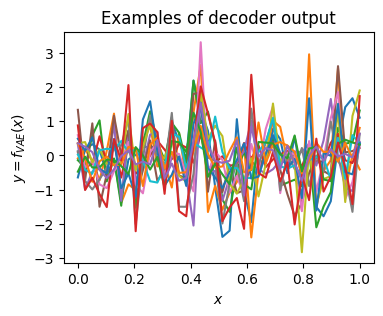

In [6]:
new_decoder = MLPDecoder(args["hidden_dim"], args["input_dim"])

key = jax.random.PRNGKey(rnd.randint(0, 9999))
rng, z_rng, init_rng = random.split(key, 3)
z = random.normal(z_rng, (args["batch_size"], args["latent_dim"]))
c = .4 * jnp.ones((z.shape[0], 1))
z_c = jnp.concatenate([z, c], axis=-1)

key = jax.random.PRNGKey(rnd.randint(0, 9999))
key, rng = jax.random.split(key, 2)
params = new_decoder.init(rng, z_c)['params']

out = new_decoder.apply({'params': params}, z_c)             

fig, ax = plt.subplots(figsize=(4,3))
for i in range(15):
    ax.plot(sample_x_train[0], out[i,:])
ax.set_xlabel('$x$')
ax.set_ylabel('$y=f_{VAE}(x)$')
ax.set_title('Examples of decoder output')

plt.show()

## Load the model

In [7]:
trained_decoder_params = load_model_params(args["model_path"])["decoder"]

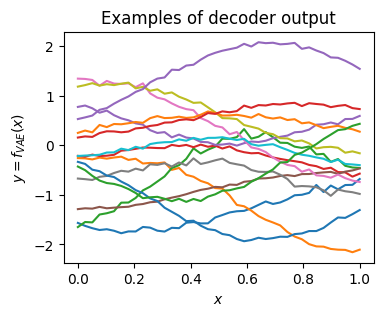

In [8]:
# apply decoder with trained parameters on the data
out = new_decoder.apply({'params': trained_decoder_params}, z_c)             

fig, ax = plt.subplots(figsize=(4,3))
for i in range(15):
    ax.plot(sample_x_train[0], out[i,:])
ax.set_xlabel('$x$')
ax.set_ylabel('$y=f_{VAE}(x)$')
ax.set_title('Examples of decoder output')

plt.show()